In [1]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
from helper.utils import *
from helper.model import *
from helper.distance_map import *
from helper.evaluate import *
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import re
plt.rcParams["figure.autolayout"] = True
converter_EC = re.compile(r'\d\.*\.*\.*')

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype =  torch.float32
print('device used: ', device)
torch.backends.cudnn.benchmark = True

checkpoint = torch.load('./model/uniref100_full0_triplet.pth')
model = LayerNormNet(hidden_dim = 512, out_dim = 128, dtype=dtype, device=device)
model.load_state_dict(checkpoint)
model_triplet = model.to(device)
####### load supcon
checkpoint = torch.load('./model/uniref10/uniref10_split0_supcon.pth')
model = LayerNormNet(hidden_dim = 512, out_dim = 256, dtype=dtype, device=device)
model.load_state_dict(checkpoint)
model_supcon = model.to(device)
 

device used:  cuda:0


In [2]:
id_ec_dict, ec_id_dict = get_ec_id_dict_non_prom(
    './data/uniref100_full.csv')
id_ec = list(id_ec_dict.keys())
y = [id_ec_dict[id][0] for id in id_ec]
# emb_triplet = model_embedding_test(id_ec_dict, model_triplet, device, dtype)
# lookup_triplet = emb_triplet.detach().cpu().numpy()
# emb_supcon = model_embedding_test(id_ec_dict, model_supcon, device, dtype)
# lookup_supcon = emb_supcon.detach().cpu().numpy()
# emb_esm = model_embedding_test(id_ec_dict, lambda *args: args[0], device, dtype)
# lookup_esm = emb_esm.detach().cpu().numpy()

In [7]:
# hard_ec = ['1.3.1.98', '1.2.1.70',
#            '2.3.2.27', '2.7.7.6',
#            '3.6.4.12', '3.1.3.16',
#            '4.1.1.65', '4.1.1.65',
#            '5.1.1.1', '5.4.99.25',
#            '6.1.1.20', '6.3.4.19',
#            '7.1.2.2', '7.1.1.9'
#            ]
hard_ec = ['1.3.1.98', '1.2.1.70',
           '2.7.4.3', '2.7.11.1',
           '3.1.26.4', '3.6.4.12',
           '4.1.1.65', '4.2.1.33',
           '5.1.1.1', '5.2.1.8',
           '6.1.1.20', '6.3.4.19',
           '7.1.2.2', '7.1.1.9'
           ]
# hard_ec = [ ]
# avoid_ec = ['3.6.4.13', '2.7.7.6', '2.3.2.27', '2.7.11.1', '5.2.1.8',]
avoid_ec = []
# avoid_ec = ['3.6.4.13',  '2.3.2.27', '2.7.11.1']

# avoid_ec = []
idx = []
idx_grey = []
appeared_EC = set()
count = 0
count2 = 0
i = 0
for ec in tqdm(y):
    if (y.count(ec) >= 20 and ec not in avoid_ec) and (ec in hard_ec or y.count(ec) >= 5000):
        # if ec not in appeared_EC:
        #     print("EC:", ec, "Number of sequences:", y.count(ec))
        appeared_EC.add(ec)
        count += 1
        idx.append(i)
    else:
        count2 += 1
        idx_grey.append(i)
    i += 1


100%|██████████| 215439/215439 [24:59<00:00, 143.66it/s]


In [10]:
fig.savefig('t-SNE.png', dpi=600)

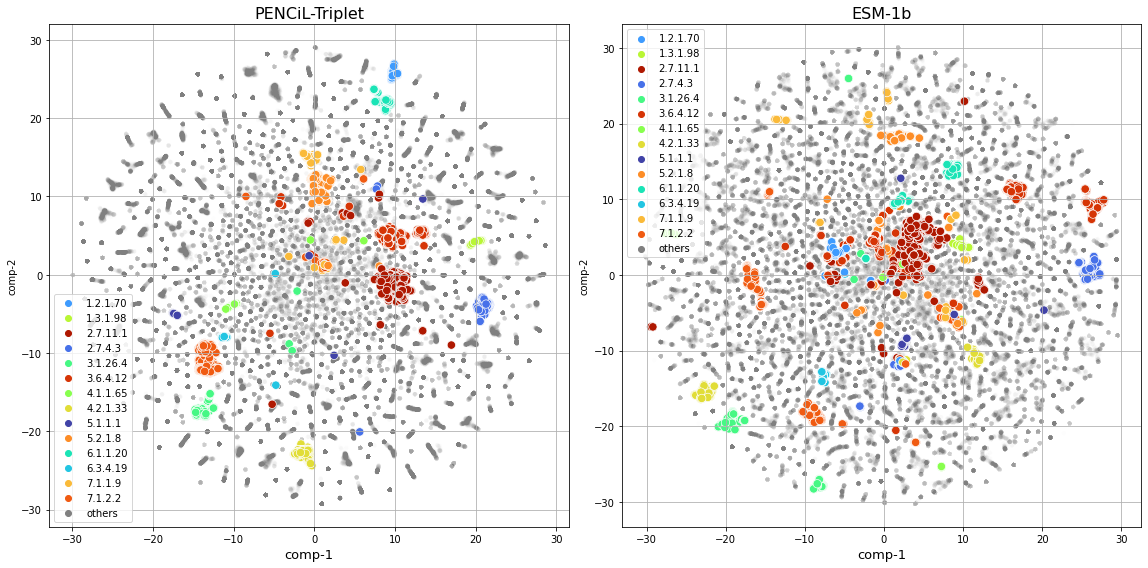

In [9]:
title_size = 16
label_size = 13
legend_size = 10
#############################################################################
fig = plt.figure(figsize=(24, 8))
ax1 = fig.add_subplot(131)
plt.grid()
ax2 = fig.add_subplot(132)
plt.grid()
 
# triplet results
z = np.load("uniref100_triple.npy")
df = pd.DataFrame()
y_array = np.array(y)
y_array[idx_grey] = 'others'
df["y"] = y_array
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]
# print(len(set(np.array(y)[idx])))
sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df[df.y == 'others'].y.tolist(), s=20,
                data=df[df.y == 'others'], ax=ax1, alpha=0.01, palette="gist_gray")
sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df[df.y != 'others'].y.tolist(), s=70,
                data=df[df.y != 'others'], ax=ax1, alpha=1, palette='turbo_r')
handles, labels = ax1.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax1.legend(handles, labels, fontsize=legend_size)
ax1.set_title("PENCiL-Triplet", fontsize=title_size)
##########===================================================###########################
z = np.load("uniref100_esm.npy")
df = pd.DataFrame()
y_array = np.array(y)
y_array[idx_grey] = 'others'
df["y"] = y_array
#df["y"] = np.array([converter_EC.search(ec).group(0) + '_._._' for ec in y]) 
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]
# print(len(set(np.array(y)[idx])))
sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df[df.y == 'others'].y.tolist(), s=20,
                data=df[df.y == 'others'], ax=ax2, alpha=0.01, palette="gist_gray")
sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df[df.y != 'others'].y.tolist(), s=70,
                data=df[df.y != 'others'], ax=ax2, alpha=1, palette='turbo_r')
handles, labels = ax2.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax2.legend(handles, labels, fontsize=legend_size)
ax2.set_title("ESM-1b", fontsize=title_size)
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=label_size)
fig.savefig('t-SNE.png', dpi=600)

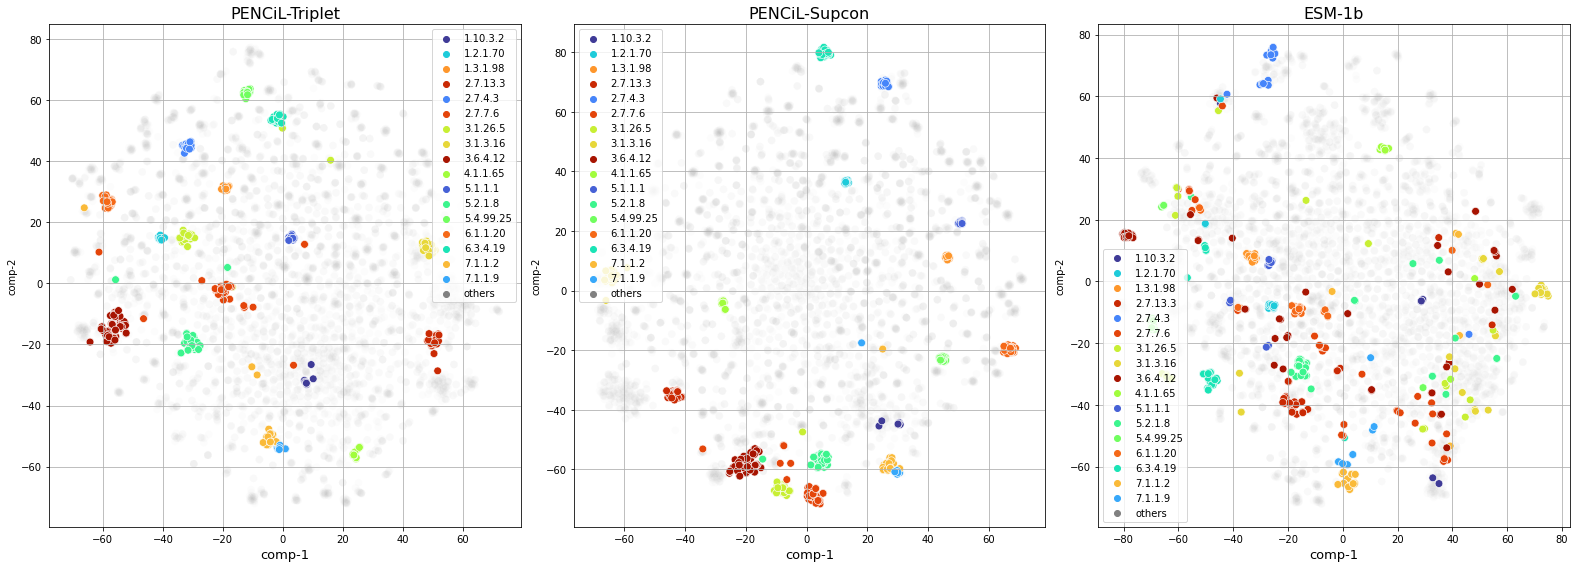

In [23]:
title_size = 16
label_size = 13
legend_size = 10
#############################################################################
fig = plt.figure(figsize=(22, 8))
ax1 = fig.add_subplot(131)
plt.grid()
ax2 = fig.add_subplot(132)
plt.grid()
ax3 = fig.add_subplot(133)
plt.grid()
# triplet results
tsne = TSNE(n_components=2, verbose=0, random_state=123, n_iter=750)
z = tsne.fit_transform(lookup_triplet)
df = pd.DataFrame()
y_array = np.array(y)
y_array[idx_grey] = 'others'
df["y"] = y_array
#df["y"] = np.array([converter_EC.search(ec).group(0) + '_._._' for ec in y]) 
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]
# print(len(set(np.array(y)[idx])))
sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df[df.y == 'others'].y.tolist(), s=60,
                data=df[df.y == 'others'], ax=ax1, alpha=0.02, palette="gist_gray")
sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df[df.y != 'others'].y.tolist(), s=60,
                data=df[df.y != 'others'], ax=ax1, alpha=1, palette='turbo_r')
handles, labels = ax1.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax1.legend(handles, labels, fontsize=legend_size)
ax1.set_title("PENCiL-Triplet", fontsize=title_size)
# # supcon results
# tsne = TSNE(n_components=2, verbose=0, random_state=123, n_iter=750)
# z = tsne.fit_transform(lookup_supcon)
# df = pd.DataFrame()
# y_array = np.array(y)
# y_array[idx_grey] = 'others'
# df["y"] = y_array
# #df["y"] = np.array([converter_EC.search(ec).group(0) + '_._._' for ec in y]) 
# df["comp-1"] = z[:, 0]
# df["comp-2"] = z[:, 1]
# # print(len(set(np.array(y)[idx])))
# sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df[df.y == 'others'].y.tolist(), s=60,
#                 data=df[df.y == 'others'], ax=ax2, alpha=0.02, palette="gist_gray")
# sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df[df.y != 'others'].y.tolist(), s=60,
#                 data=df[df.y != 'others'], ax=ax2, alpha=1, palette='turbo_r')
# handles, labels = ax2.get_legend_handles_labels()
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
# ax2.legend(handles, labels, fontsize=legend_size)
# ax2.set_title("PENCiL-Supcon", fontsize=title_size)

# # esm results
tsne = TSNE(n_components=2, verbose=0, random_state=123, n_iter=750)
z = tsne.fit_transform(lookup_esm)
df = pd.DataFrame()
y_array = np.array(y)
y_array[idx_grey] = 'others'
df["y"] = y_array
#df["y"] = np.array([converter_EC.search(ec).group(0) + '_._._' for ec in y]) 
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]
# print(len(set(np.array(y)[idx])))
sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df[df.y == 'others'].y.tolist(), s=60,
                data=df[df.y == 'others'], ax=ax3, alpha=0.02, palette="gist_gray")
sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df[df.y != 'others'].y.tolist(), s=60,
                data=df[df.y != 'others'], ax=ax3, alpha=1, palette='turbo_r')
handles, labels = ax3.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax3.legend(handles, labels, fontsize=legend_size)
ax3.set_title("ESM-1b", fontsize=title_size)
###########################################################################
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=label_size)
fig.savefig('../t-SNE.png')
